
Things to correct/do in the code:
1.  Ways to improve gather_png_data? Currently takes a lot of ram
2.  Fix the spliting code --> use built in train/validation split functions? Currently doubles RAM usage - HIGHLY inefficient
3.  Clean up code for model epochs into 1 block
4.  Consider changing model design - more layers? CNN?
5.  Separate code into 2 parts - one for training model and saving, one for loading model and viewing 
6.  In viewing code: 
  - add a table that displays all predictions in 1 place for easy reference
  - clean up bar graph percentages (gets messy when many categories present)
  - add softmax layer after loading model
  - redessgin the reading in code function to take also individual image names



In [18]:
# model library
import tensorflow as tf

# image processing libraries
from keras.utils import load_img
from keras.utils import img_to_array
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math

# folder reading libraries
import glob
import os
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/
/content/drive/My Drive/CV data


In [44]:
%cd "/content/drive/My Drive/Maldonado Lab"

/content/drive/My Drive/Maldonado Lab


In [68]:
def gather_png_data(folder_path): # function to read in PNG image files
    files = glob.glob(folder_path + "/*.png")
    img_array = []
    for img in files:
        img = load_img(img, color_mode = "grayscale")
        img = img_to_array(img)  # convert PIL format to numpy array (note: 255 is white and 0 black)
        img_array.append(img)
    img_array = np.array(img_array)
    # map values to 0-1 such that 0 represents white, 1 represents black: better for model to process since white is not needed
    img_array = -(img_array/255) + 1
    return np.squeeze(img_array)

def listdir_non_hidden(folder_path): # function to only gather non-hidden folders
    folders = []
    for folder in os.listdir(folder_path):
        if not folder.startswith('.'):
            folders.append(folder)
    return folders
    
def display_predictions(category, number): # takes in the index of the category and the index position of exprimental data 
    fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 2]}, figsize=(25,10))
    # first subplot
    ax[0].imshow(exp_datas[category][number], cmap= "binary")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title(f"Experimental Category: {exp_folder[category]}", size = 20)

    # second subplot 
    thisplot = ax[1].bar(range(len(labels)), predictions[category][number], color="#FFCCCB")
    ax[1].set_xticks(range(len(labels)))
    ax[1].set_yticks([])
    ax[1].set_ylim([0,1])
    predicted_label = np.argmax(predictions[category][number])
    thisplot[predicted_label].set_color('#90EE90')
    ax[1].set_title(f"Predicted Category: {predicted_label} ({labels[predicted_label]})", size = 20)
    # to label each bar with percentage on top   
    for i, v in enumerate(predictions[category][number]):
        ax[1].text(i - 0.5, v + 0.01, str(round(v*100,2)) + '%', color='blue', rotation = 45, size = 8)
    

In [26]:
# EXPERIMENTAL DATA
experimental_path = ("CV data/experimental/") # folder path of experimental data relative to code, note: add "/" at end
exp_folder = listdir_non_hidden(experimental_path)
exp_datas = []

# iterates through experimental data folder and appends data into a list
for folders in exp_folder:
    data = gather_png_data(experimental_path + folders)
    exp_datas.append(data) 

#exp_data[0] ---> first category
#exp_data[1] ---> second category


# if only one data, need to add dimensionality to be consistent (happens automatically if more than 1 exp data, COMMENT OUT BELOW CODE IF > 1)
# test_data = np.expand_dims(test_data, axis = 0)


In [27]:
exp_datas[1].shape

(10, 208, 208)

In [30]:
## NOTE: code uses approx 4.94 GB of RAM - MUST LOOK TO REDUCE.
## code takes approx 8 minutes to gather data

# TRAINING DATA
training_path = ("CV data/training/training_data_12_2_images/") # folder path of training data relative to code, note: add "/" at end
data_folder = listdir_non_hidden(training_path)
trn_data = []
class_names = []

# iterates through data folder and appends data into a list
for folders in data_folder:
    data = gather_png_data(training_path + folders)
    trn_data.append(data)

# self-made labels for easy reference into the categories folder
for i in range(len(trn_data)):
    class_names.append(i+1) # number in class_names corresponds to the number in categories array, not the index

# generates category labels based on training data folder names
labels = []
for folders in data_folder:
    labels.append(folders)

In [31]:
## NOTE: code is inefficient!!! RAM usage doubled after running cell: potential reason: a different variable name was declared to hold same data in numpy stacked form (form used to feed into model)

split_percent = 30 # represents the percentage of validation data for each category that will be taken out

train_labels = []
validation_labels = []
split_arr = []

for i in range(len(trn_data)):
    # split data into training and validation sets
    x = round(trn_data[i].shape[0] * split_percent/100)
    split = np.array_split(trn_data[i],[0,x],axis=0) # array split returns 3 values of sub_arrays, 1 being a 0 dimension (useless)
    split_arr.append(split)
    
    # generate own labels for training purposes into train & validate group, i.e. each data[i] group is its own category
    for j in range(len(trn_data[i])):
        if j<x:
            validation_labels.append(i)
        else:
            train_labels.append(i)
# convert labels to numpy array to input into model         
train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)

# create training & validating set by stacking along axis = 0
validation = []
train = []
for i in range(len(split_arr)):
    validation.append(split_arr[i][1])
    train.append(split_arr[i][2])

train_data = np.vstack(train)
validation_data = np.vstack(validation)

x,y= train_data.shape[1],train_data.shape[2]

In [32]:
model = tf.keras.Sequential([ #number of nodes were arbitarily set based on validation accuracy 
    tf.keras.layers.Flatten(input_shape=(x,y)),
    tf.keras.layers.Dense(len(labels)*2, activation='relu'),
    tf.keras.layers.Dense(len(labels))])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_data, train_labels, epochs=8) 
# 40 epochs take avg 20 x 40 = 800 seconds (~13 minutes)
# slow training accuracy - peaks around 95%

validate_loss, validate_acc = model.evaluate(validation_data,  validation_labels, verbose=2, batch_size=32) #verbose is method of acknowledging program is running
print('\nValidation accuracy:', validate_acc)

Epoch 1/8
526/526 [==============================] - 18s 32ms/step - loss: 2.2419 - accuracy: 0.2284
Epoch 2/8
526/526 [==============================] - 17s 32ms/step - loss: 1.6093 - accuracy: 0.3478
Epoch 3/8
526/526 [==============================] - 17s 32ms/step - loss: 1.4063 - accuracy: 0.4115
Epoch 4/8
526/526 [==============================] - 18s 34ms/step - loss: 1.2656 - accuracy: 0.4668
Epoch 5/8
526/526 [==============================] - 24s 45ms/step - loss: 1.1571 - accuracy: 0.5118
Epoch 6/8
526/526 [==============================] - 19s 35ms/step - loss: 1.0391 - accuracy: 0.5642
Epoch 7/8
526/526 [==============================] - 23s 45ms/step - loss: 0.9737 - accuracy: 0.5952
Epoch 8/8
526/526 [==============================] - 20s 38ms/step - loss: 0.9018 - accuracy: 0.6279
226/226 - 2s - loss: 0.9513 - accuracy: 0.5976 - 2s/epoch - 10ms/step

Validation accuracy: 0.5975576043128967


In [33]:
model.fit(train_data, train_labels, epochs=8)

Epoch 1/8
526/526 [==============================] - 18s 34ms/step - loss: 0.8273 - accuracy: 0.6657
Epoch 2/8
526/526 [==============================] - 17s 33ms/step - loss: 0.7716 - accuracy: 0.6894
Epoch 3/8
526/526 [==============================] - 18s 34ms/step - loss: 0.7130 - accuracy: 0.7240
Epoch 4/8
526/526 [==============================] - 22s 42ms/step - loss: 0.6667 - accuracy: 0.7469
Epoch 5/8
526/526 [==============================] - 19s 36ms/step - loss: 0.6258 - accuracy: 0.7622
Epoch 6/8
526/526 [==============================] - 17s 33ms/step - loss: 0.5830 - accuracy: 0.7888
Epoch 7/8
526/526 [==============================] - 21s 39ms/step - loss: 0.5594 - accuracy: 0.7943
Epoch 8/8
526/526 [==============================] - 19s 36ms/step - loss: 0.5266 - accuracy: 0.8160


In [34]:
validate_loss, validate_acc = model.evaluate(validation_data,  validation_labels, verbose=2, batch_size=32) #verbose is method of acknowledging program is running
print('\nValidation accuracy:', validate_acc)
model.fit(train_data, train_labels, epochs=8)

226/226 - 2s - loss: 0.5442 - accuracy: 0.8114 - 2s/epoch - 10ms/step

Validation accuracy: 0.8114071488380432
Epoch 1/8
526/526 [==============================] - 17s 33ms/step - loss: 0.5001 - accuracy: 0.8269
Epoch 2/8
526/526 [==============================] - 17s 32ms/step - loss: 0.4678 - accuracy: 0.8455
Epoch 3/8
526/526 [==============================] - 17s 32ms/step - loss: 0.4411 - accuracy: 0.8565
Epoch 4/8
526/526 [==============================] - 17s 32ms/step - loss: 0.4459 - accuracy: 0.8477
Epoch 5/8
526/526 [==============================] - 17s 32ms/step - loss: 0.4115 - accuracy: 0.8610
Epoch 6/8
526/526 [==============================] - 17s 32ms/step - loss: 0.3848 - accuracy: 0.8823
Epoch 7/8
526/526 [==============================] - 17s 33ms/step - loss: 0.3653 - accuracy: 0.8922
Epoch 8/8
526/526 [==============================] - 17s 33ms/step - loss: 0.3570 - accuracy: 0.8943


In [35]:
validate_loss, validate_acc = model.evaluate(validation_data,  validation_labels, verbose=2, batch_size=32) #verbose is method of acknowledging program is running
print('\nValidation accuracy:', validate_acc)
model.fit(train_data, train_labels, epochs=8)

226/226 - 2s - loss: 0.3631 - accuracy: 0.8752 - 2s/epoch - 11ms/step

Validation accuracy: 0.8752428293228149
Epoch 1/8
526/526 [==============================] - 17s 32ms/step - loss: 0.3351 - accuracy: 0.9036
Epoch 2/8
526/526 [==============================] - 17s 32ms/step - loss: 0.3195 - accuracy: 0.9146
Epoch 3/8
526/526 [==============================] - 20s 39ms/step - loss: 0.3055 - accuracy: 0.9158
Epoch 4/8
526/526 [==============================] - 19s 36ms/step - loss: 0.2987 - accuracy: 0.9136
Epoch 5/8
526/526 [==============================] - 17s 32ms/step - loss: 0.2804 - accuracy: 0.9260
Epoch 6/8
526/526 [==============================] - 17s 33ms/step - loss: 0.2840 - accuracy: 0.9216
Epoch 7/8
526/526 [==============================] - 17s 32ms/step - loss: 0.2650 - accuracy: 0.9329
Epoch 8/8
526/526 [==============================] - 17s 32ms/step - loss: 0.2456 - accuracy: 0.9361


In [37]:
validate_loss, validate_acc = model.evaluate(validation_data,  validation_labels, verbose=2, batch_size=32) #verbose is method of acknowledging program is running
print('\nValidation accuracy:', validate_acc)
model.fit(train_data, train_labels, epochs=8)

226/226 - 2s - loss: 0.2961 - accuracy: 0.9262 - 2s/epoch - 10ms/step

Validation accuracy: 0.9261726140975952
Epoch 1/8
526/526 [==============================] - 18s 34ms/step - loss: 0.2576 - accuracy: 0.9266
Epoch 2/8
526/526 [==============================] - 25s 47ms/step - loss: 0.2362 - accuracy: 0.9411
Epoch 3/8
526/526 [==============================] - 17s 33ms/step - loss: 0.2600 - accuracy: 0.9219
Epoch 4/8
526/526 [==============================] - 17s 33ms/step - loss: 0.2115 - accuracy: 0.9491
Epoch 5/8
526/526 [==============================] - 18s 34ms/step - loss: 0.2137 - accuracy: 0.9483
Epoch 6/8
526/526 [==============================] - 20s 37ms/step - loss: 0.2270 - accuracy: 0.9395
Epoch 7/8
526/526 [==============================] - 19s 35ms/step - loss: 0.1882 - accuracy: 0.9601
Epoch 8/8
526/526 [==============================] - 20s 37ms/step - loss: 0.1983 - accuracy: 0.9511


In [38]:
validate_loss, validate_acc = model.evaluate(validation_data,  validation_labels, verbose=2, batch_size=32) #verbose is method of acknowledging program is running
print('\nValidation accuracy:', validate_acc)

226/226 - 2s - loss: 0.2042 - accuracy: 0.9602 - 2s/epoch - 9ms/step

Validation accuracy: 0.9601720571517944


In [49]:
path = 'weights/attempt1/'
model.save_weights(path)

 checkpoint   weights/                      weights.index
'CV data'/    weights.data-00000-of-00001


In [52]:
cv_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [100]:
print("The following experimental datas are available: ")
for i, folders in enumerate(exp_folder):
  print(f"exp_datas[{i}]:", folders,f", number of images: {len(exp_data[i])}")

The following experimental datas are available: 
exp_datas[0]: Benzyl Viologen_10^15Doped_Methanol_images , number of images: 14
exp_datas[1]: MV_LD_Air_images , number of images: 10


In [55]:
predictions = []
for i in range(len(exp_datas)):
  prediction = cv_model.predict(exp_datas[i], batch_size = 32)
  predictions.append(prediction)

1/1 [==============================] - 0s 20ms/step


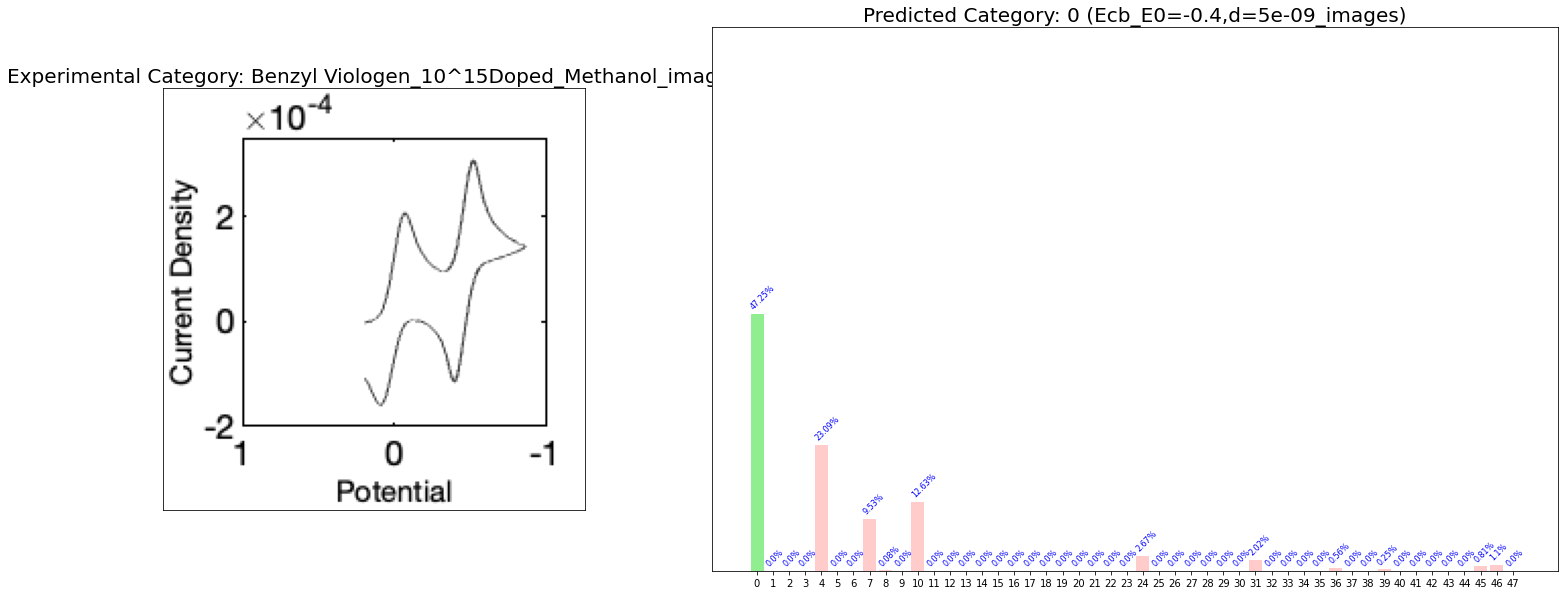

In [101]:
display_predictions(0,13)